In [1]:
# load necessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
import pickle
import mlflow

from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score, log_loss, plot_confusion_matrix
from sklearn import datasets
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# load data
df = pd.read_csv('../data/penguins.csv')

# data preprocessing
df=df.drop_duplicates()
df.dropna(axis=0,inplace=True)

# one hot encoding - nominal data
encoder=ce.OneHotEncoder(cols=['species','island'],handle_unknown='return_nan', return_df=True,use_cat_names=True)
df_enc=encoder.fit_transform(df)

# add a new column with labels
df_enc.loc[df_enc.sex == 'male', 'label'] = int(1)
df_enc.loc[df_enc.sex == 'female', 'label'] = int(0)
df_enc['label'].astype('float')

# check number of males/females to inspect if dataset is imbalanced
df_enc['label'].value_counts()

# get labels
labels = df_enc[['label']]
y = labels.to_numpy().reshape(-1,)

# drop useless columns
df_enc.drop(columns=['rowid','sex'],axis=1,inplace=True)

# get features
X = df_enc.iloc[:,:11].values

# split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [2]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")
mlflow.list_experiments()

tracking URI: 'file:///Users/mikhailkuklin/repos/WIP_mlflow_models_registry_example/notebooks/mlruns'


[<Experiment: artifact_location='file:///Users/mikhailkuklin/repos/WIP_mlflow_models_registry_example/notebooks/mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>]

In [3]:
def train_log_reg(X_train, y_train, regularization):
      np.random.seed(0)
      scaler = StandardScaler()
      log_reg = LogisticRegression(C=regularization, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False)
      pipe_def_model = Pipeline([('scaler', scaler), ('log_reg', log_reg)])
      pipe_def_model.fit(X_train, y_train)

      return pipe_def_model

In [4]:
def predict(model, X):
      y_pred = model.predict(X)
      return y_pred

In [5]:
def predict_prob(model, X):
      y_pred = model.predict_proba(X)
      return y_pred

In [6]:
def get_metrics_train(y_true, y_pred, y_pred_proba):
      acc = accuracy_score(y_true, y_pred)
      prec = precision_score(y_true, y_pred)
      recall = recall_score(y_true, y_pred)
      f1_s= f1_score(y_true, y_pred)

      return {'train-accuracy': acc, 'train-precision': prec, 'train-recall': recall, 'train-f1-score': f1_s}

In [7]:
def get_metrics_val(y_true, y_pred, y_pred_proba):
      acc = accuracy_score(y_true, y_pred)
      prec = precision_score(y_true, y_pred)
      recall = recall_score(y_true, y_pred)
      f1_s= f1_score(y_true, y_pred)

      return {'val-accuracy': acc, 'val-precision': prec, 'val-recall': recall, 'val-f1-score': f1_s}

In [8]:
def get_confusion_matrix(clf, X, y, name):
      plot_confusion_matrix(clf, X, y)
      plt.savefig(name)

In [9]:
def get_roc(clf, X, y, name):
    metrics.plot_roc_curve(clf, X, y) 
    plt.savefig(name)

/Users/mikhailkuklin/miniforge3/envs/mlflow_tacking-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/mikhailkuklin/miniforge3/envs/mlflow_tacking-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mikhailkuklin/miniforge3/envs/mlflow_tacking-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function

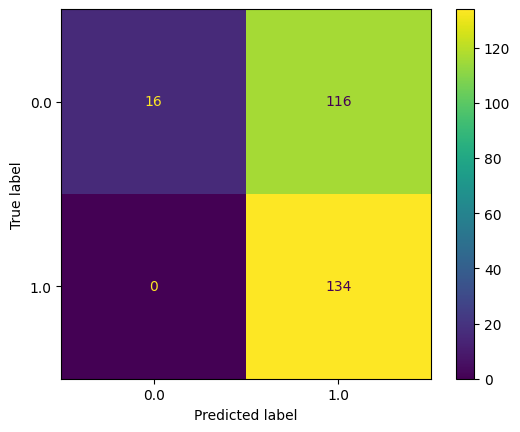

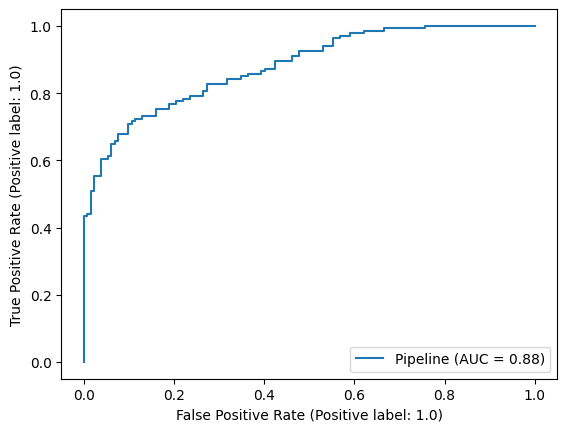

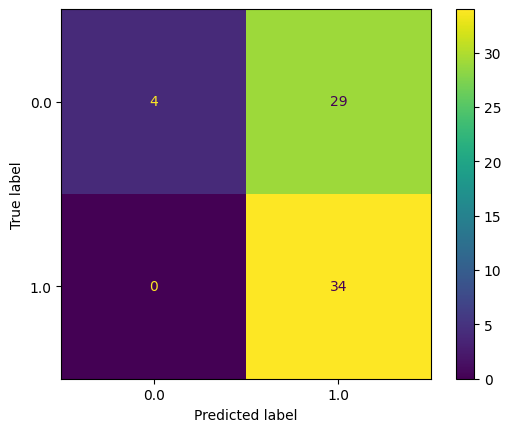

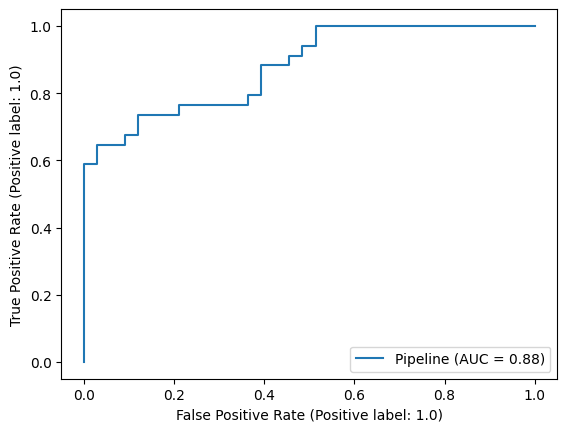

In [20]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('penguins_log_reg_register2')

model =  train_log_reg(X_train, y_train, 0.0001)

with open('models/model_log_reg.bin', 'wb') as f_out:
      pickle.dump((model), f_out)

# training set
y_pred_train = predict(model, X_train)
y_pred_proba_train = predict_prob(model, X_train)
metrics_train = get_metrics_train(y_train, y_pred_train, y_pred_proba_train)
confusion_matric_artifact = get_confusion_matrix(model, X_train, y_train, 'confusion_matrix_train.png')
roc_artifact = get_roc(model, X_train, y_train, 'roc_train.png')


# validation set
y_pred = predict(model, X_val)
y_pred_proba = predict_prob(model, X_val)
metrics_val = get_metrics_val(y_val, y_pred, y_pred_proba)
confusion_matric_artifact = get_confusion_matrix(model, X_val, y_val, 'confusion_matrix_val.png')
roc_artifact = get_roc(model, X_val, y_val, 'roc_val.png')

with mlflow.start_run():

      for metric in metrics_train:
            mlflow.log_metric(metric, metrics_train[metric])

      for metric in metrics_val:
            mlflow.log_metric(metric, metrics_val[metric])

      mlflow.log_artifact('confusion_matrix_train.png' ,'confusion_matrix_train')
      mlflow.log_artifact('confusion_matrix_val.png' ,'confusion_matrix_val')
      mlflow.log_artifact('roc_train.png', 'roc_train')
      mlflow.log_artifact('roc_val.png', 'roc_val')
      mlflow.log_param("Regularization", 0.0001)

      mlflow.set_tag("Data", "../data/penguins.csv")

      mlflow.sklearn.log_model(model, "log_reg")

      mlflow.sklearn.log_model(model, artifact_path="models_mlflow")

In [14]:
# predict using saved model

logged_model = 'runs:/2f4d03d364704e2bb2d0a19174e32a9d/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(X_val))

array([1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.])

In [15]:
# model loading - option 1

loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.sklearn
  run_id: 2f4d03d364704e2bb2d0a19174e32a9d

In [17]:
# model loading - option 2 and make predictions

log_reg_model = mlflow.sklearn.load_model(logged_model)
y_pred = predict(log_reg_model, X_val)


# Model registry

1. Compare metrics
2. Compare duration
3. Compare size of the model

Then register the model


![title](figures/model_comparison.png)

![title](figures/model_registry.png)